# Understand Open Pose PAF

This notebook looks the PAF vectorfields


In [1]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import os
import sys

sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))

import cv2
import matplotlib as mpl
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from deepexplain.tf.v1_x import DeepExplain

from plot_utils import plot, plt, plot_pose
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)

Using tf version = 1.15.0


/home/ax/miniconda3/envs/masterThesis/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [2]:
# params 432, 368
w, h = 432, 368
image_path = '../data/images/ballet_woman_man_dance_dancer-145734.jpg'
model = 'cmu'
resize_out_ratio = 2.0
image = common.read_imgfile(image_path, w, h)
image_orig_size = common.read_imgfile(image_path)

In [3]:
e = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)

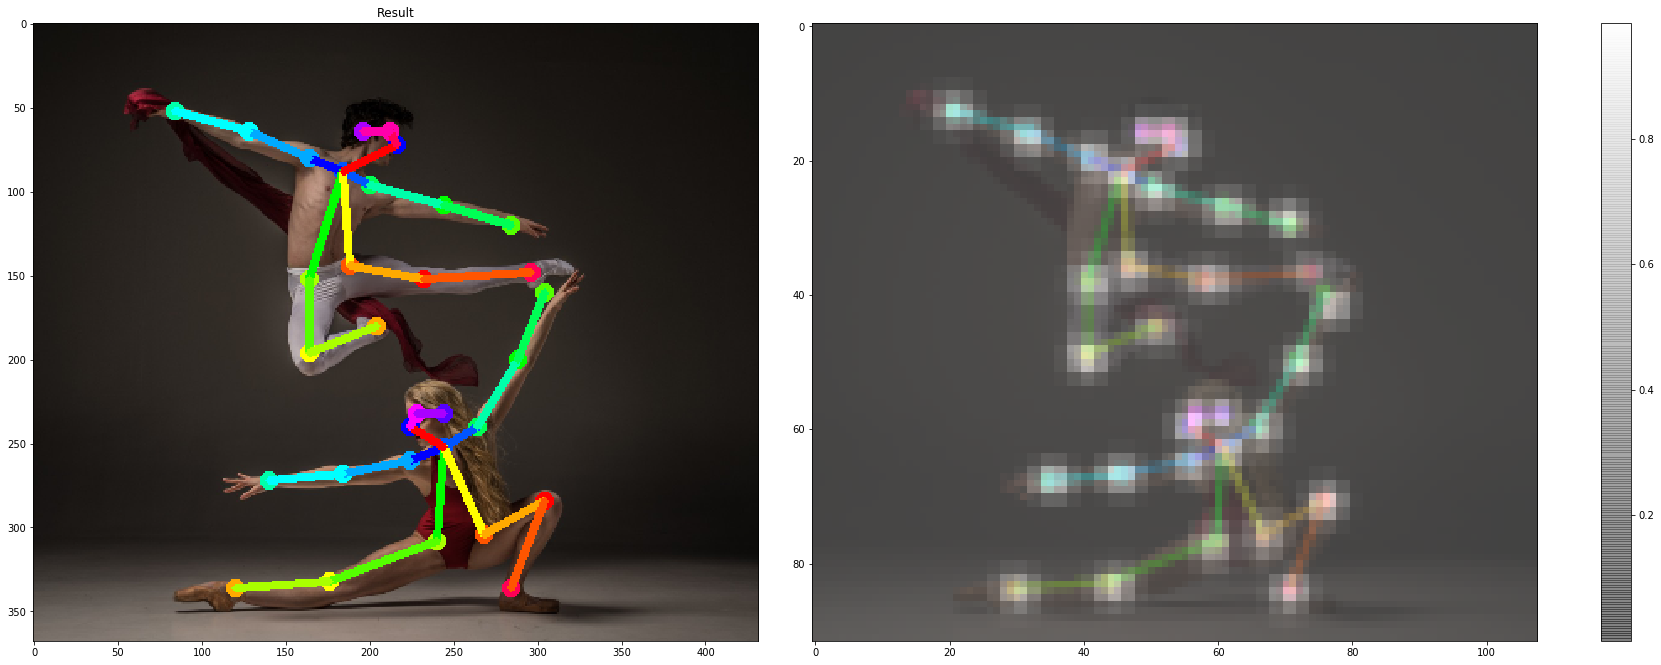

In [4]:
# estimate human poses from a single image !
humans = e.inference(image, resize_to_default=(
    w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image, humans, e.heatMat)

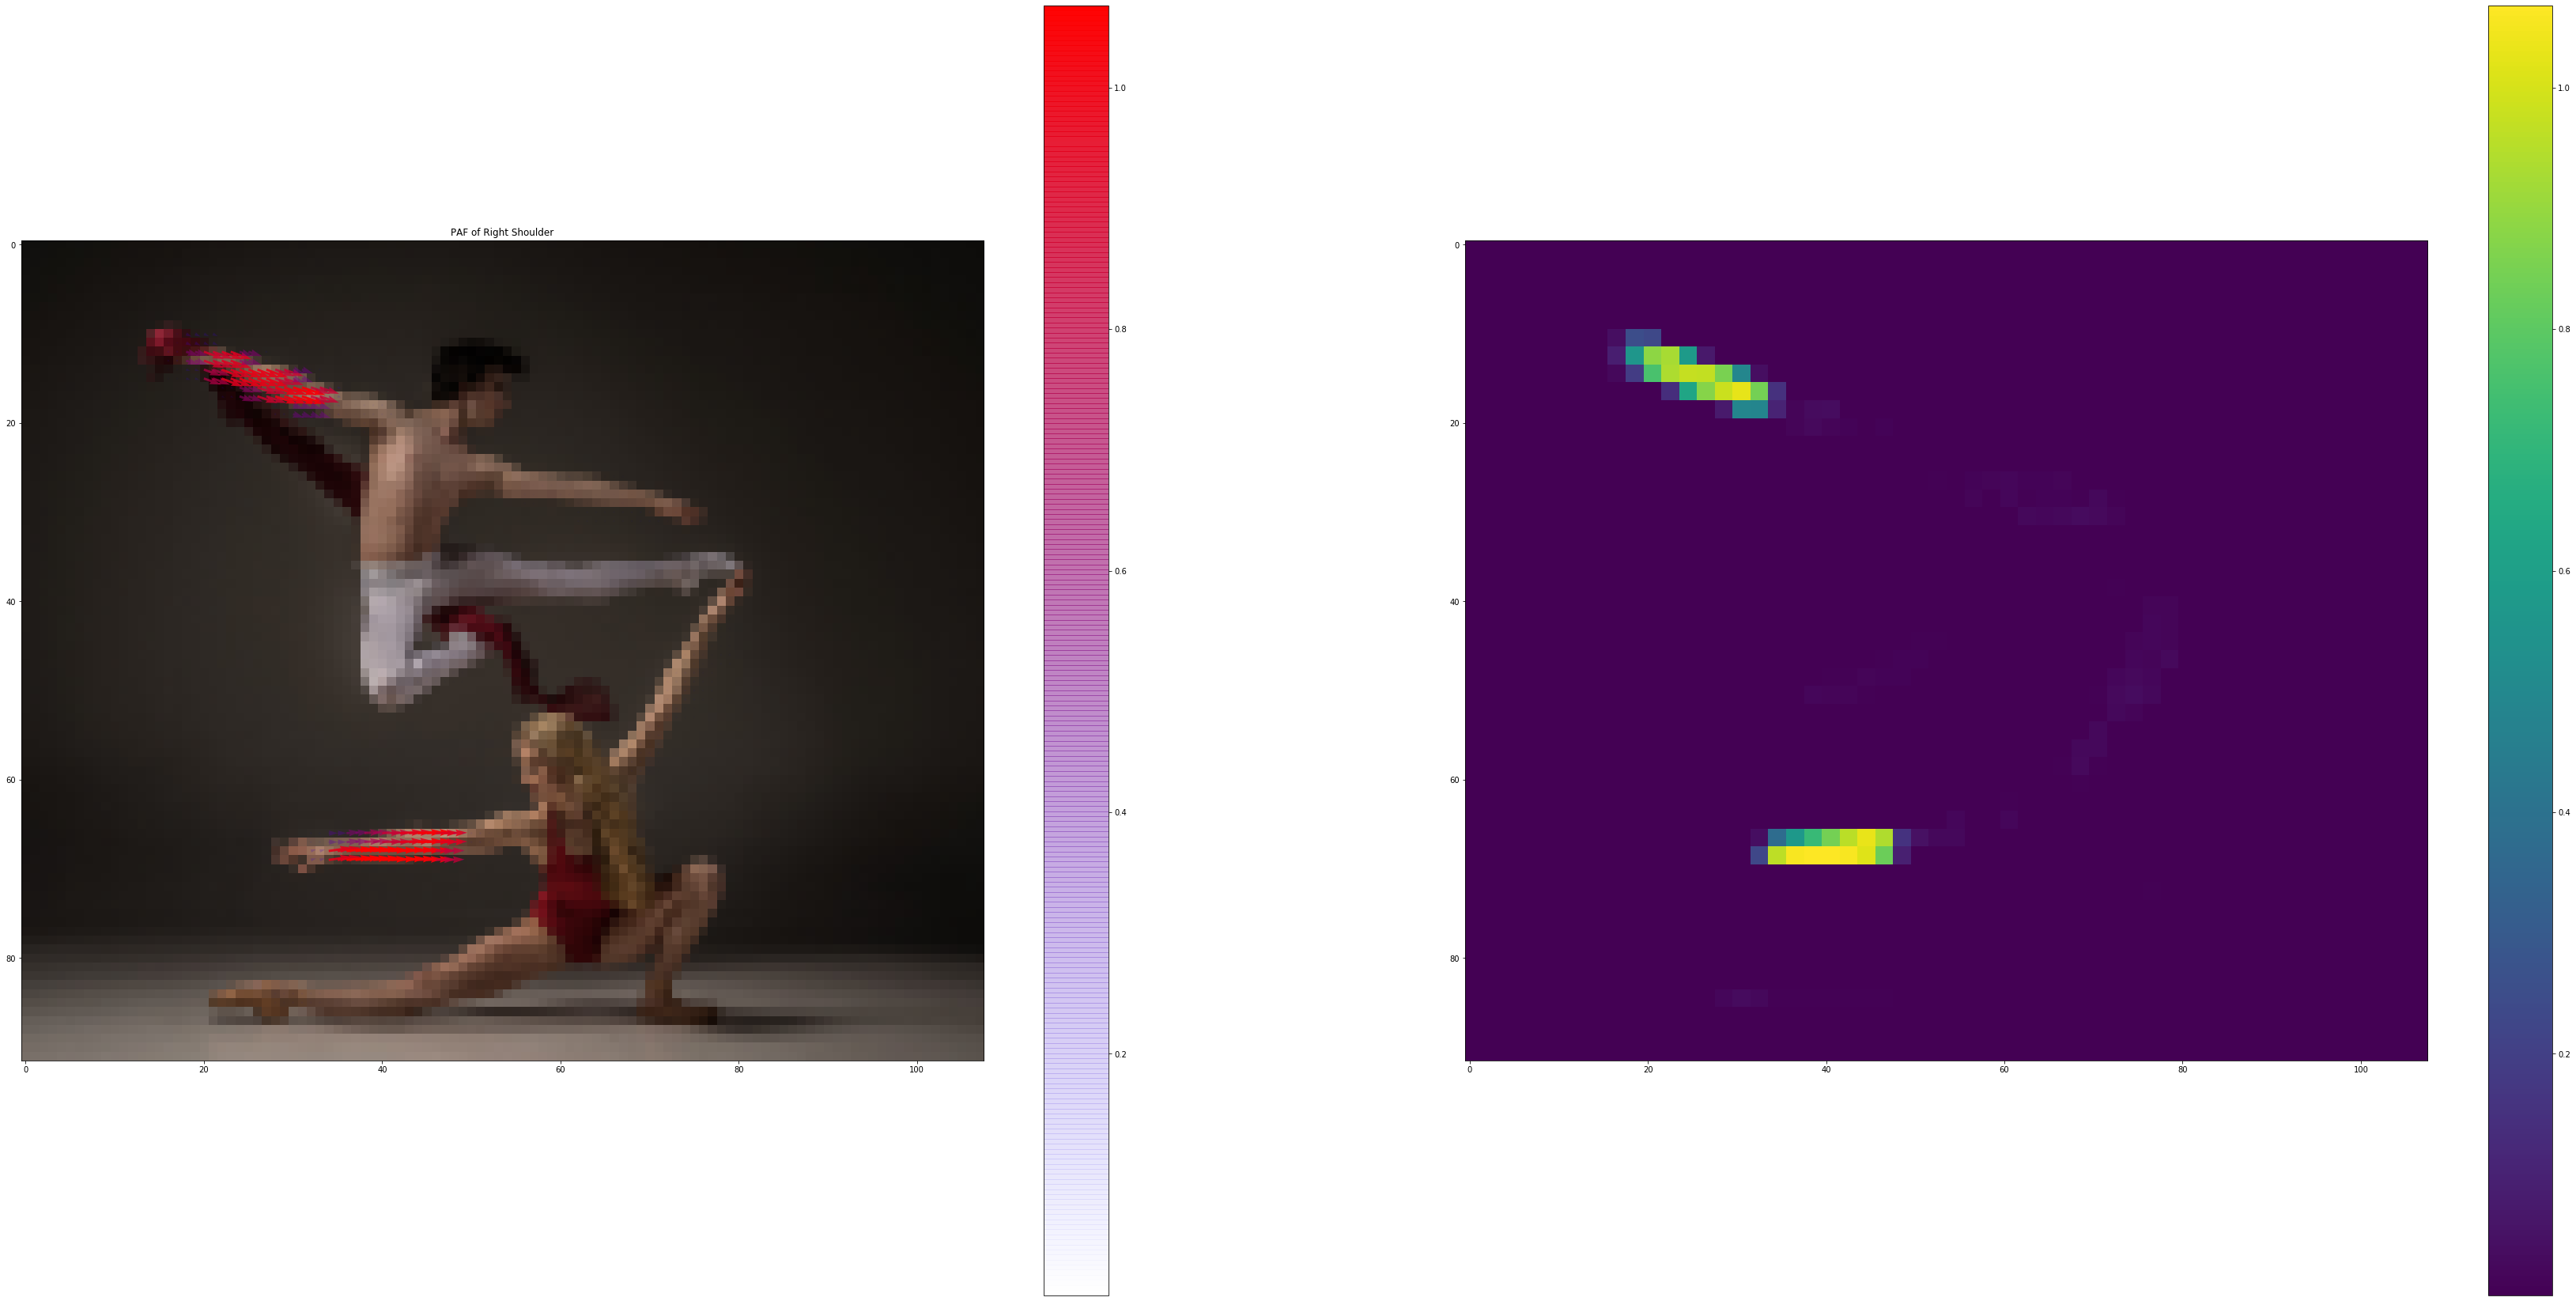

In [5]:
# 12 is neck to right shoulder
# 14 is upper arm to right shoulder
paf_id = 16
U = np.copy(e.pafMat[:, :, paf_id]) * (-1)  # why do I need this minus one
V = np.copy(e.pafMat[:, :, paf_id + 1])

fig = plt.figure(figsize=(60, 30))
ax = fig.add_subplot(1, 2, 1)

bgimg = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
bgimg = cv2.resize(
    bgimg, (U.shape[1], U.shape[0]), interpolation=cv2.INTER_AREA)
ax.imshow(bgimg, alpha=1)
X, Y = np.meshgrid(range(0, bgimg.shape[1]), range(0, bgimg.shape[0]))

color = np.sqrt(np.square(U) + np.square(V))

# normalize
#U /= color
#V /= color

colormap_transparent = mpl.colors.LinearSegmentedColormap.from_list(
    'my_cmap', ['blue', 'red'], 256)
colormap_transparent._init()  # create the _lut array, with rgba values

alphas = np.linspace(0, 1.0, colormap_transparent.N+3)
# list(map(lambda x : 1.0 if x > 0.3 else 0.0, alphas))
colormap_transparent._lut[:, -1] = alphas

heat_image = ax.quiver(X, Y, U, V, color, cmap=colormap_transparent, scale=40)
#heat_image = ax.imshow(V, cmap=plt.cm.hot, alpha=0.5)


ax.set_title('PAF of Right Shoulder')
fig.colorbar(heat_image, ax=ax, shrink=1.0)


ax = fig.add_subplot(1, 2, 2)
heat_image = ax.imshow(color)
fig.colorbar(heat_image, ax=ax, shrink=1.0)

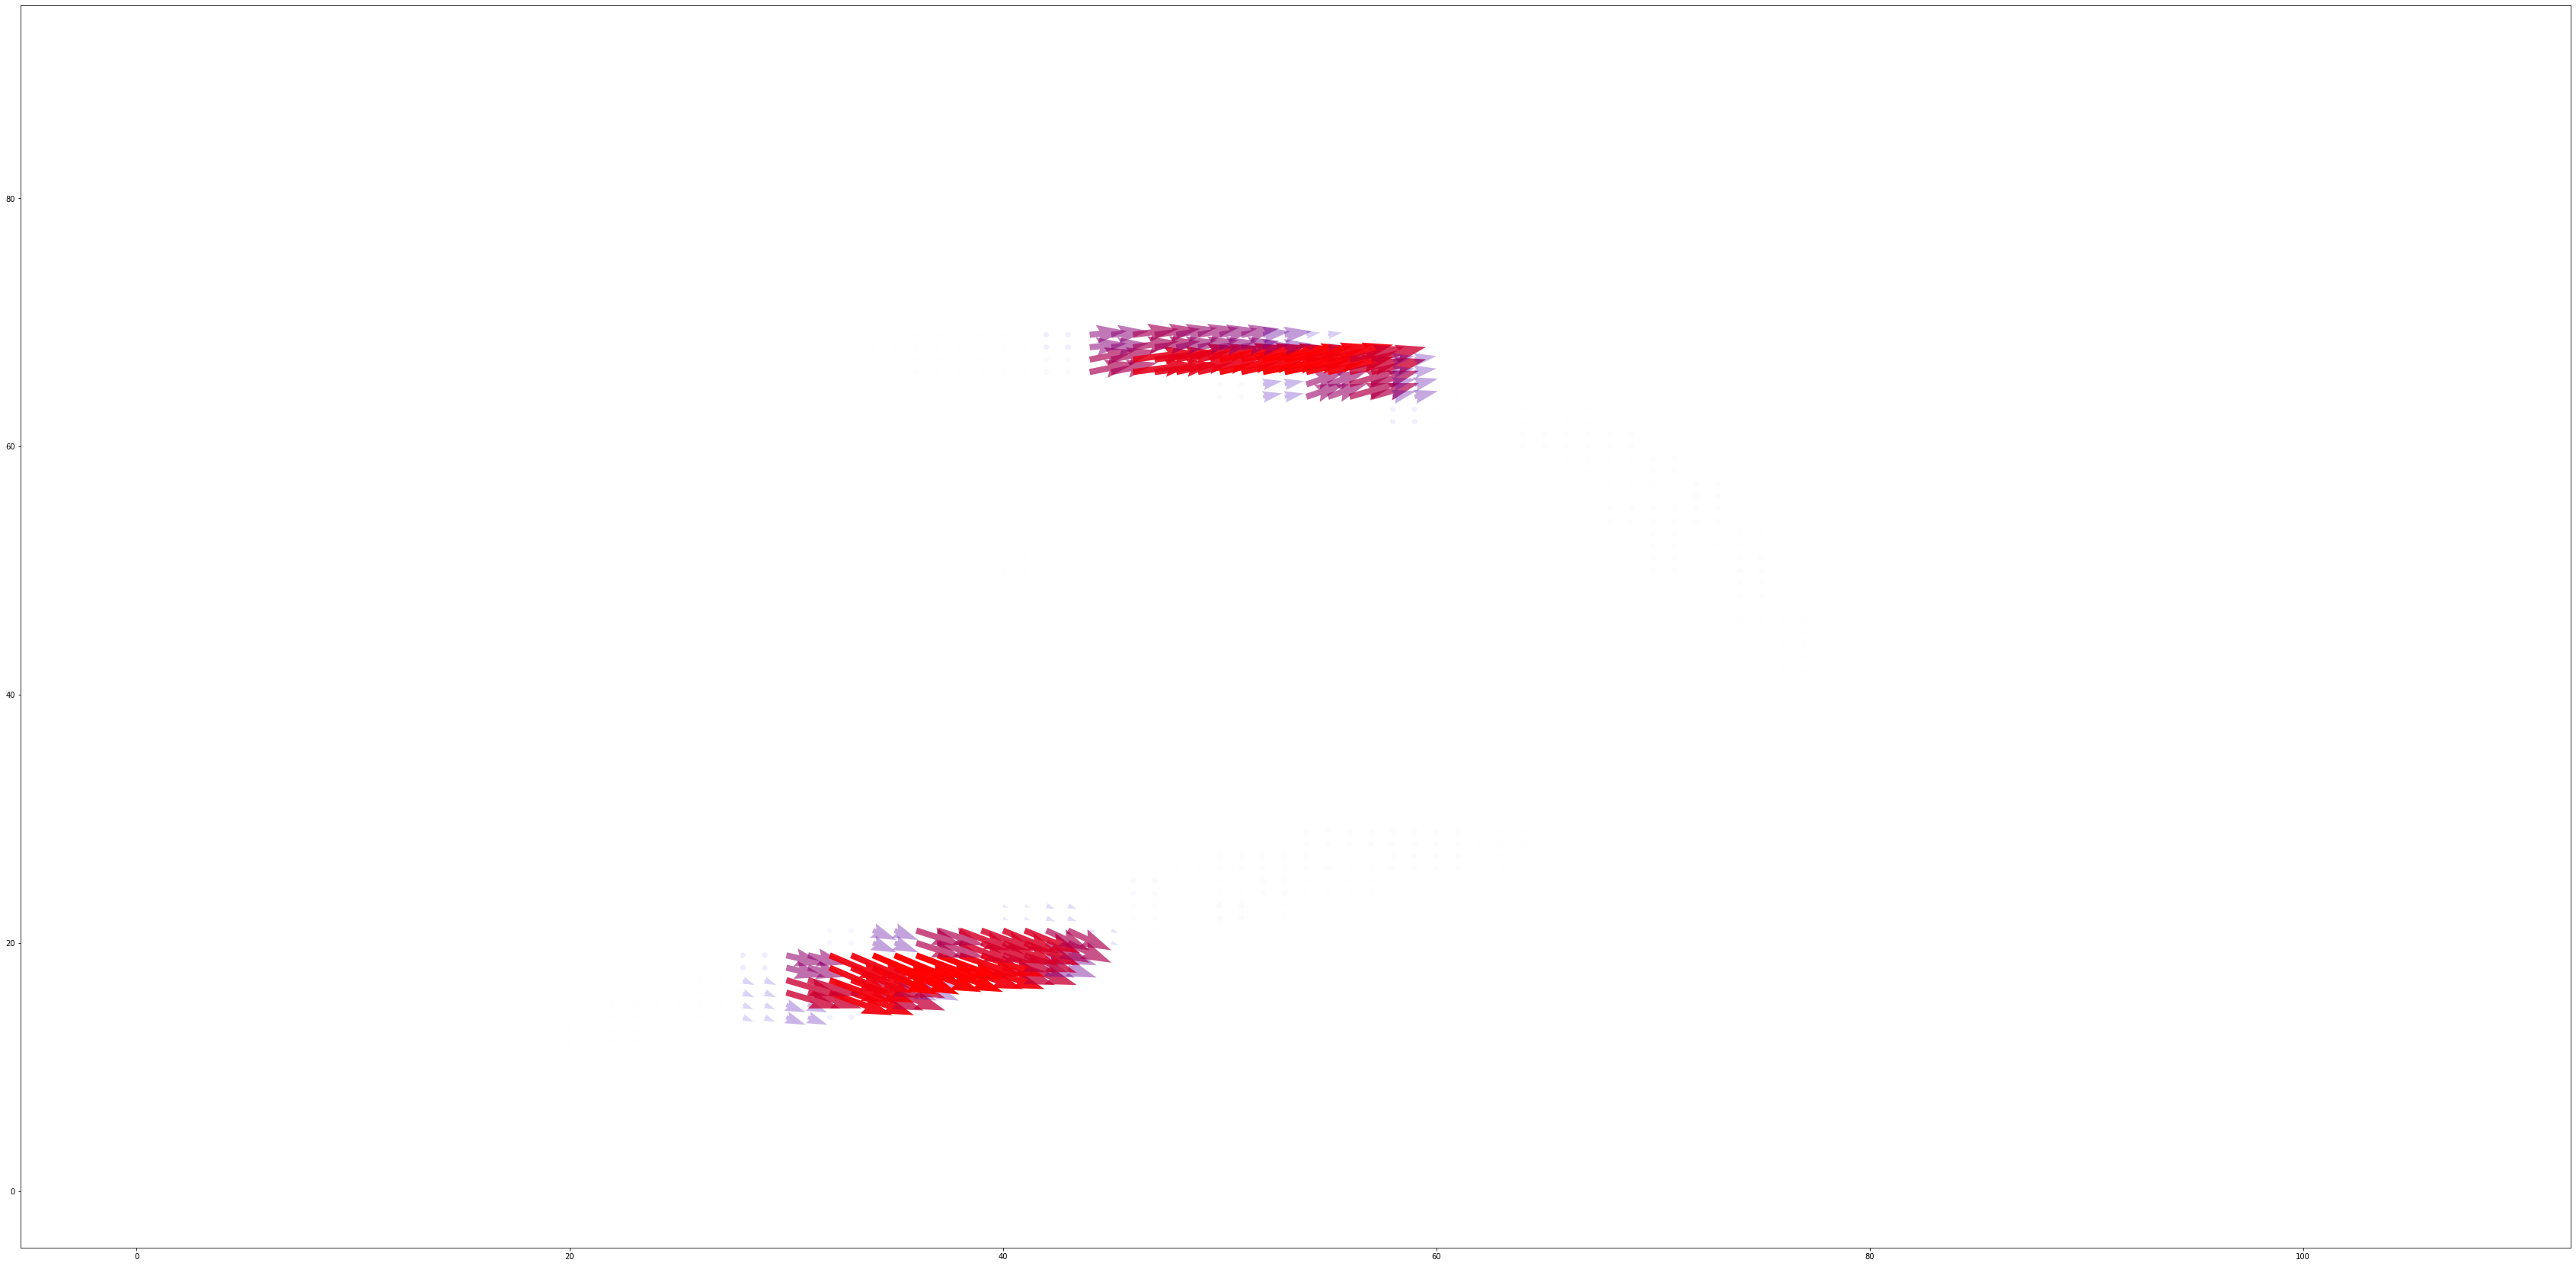

In [6]:
# 12 is neck to right shoulder
# 14 is upper arm to right shoulder
paf_id = 14
U = np.copy(e.pafMat[:, :, paf_id]) * (-1)  # why do I need this minus one
V = np.copy(e.pafMat[:, :, paf_id + 1])

fig = plt.figure(figsize=(60, 30))
ax = fig.add_subplot(1, 1, 1)

X, Y = np.meshgrid(range(0, U.shape[1]), range(0, U.shape[0]))
color = np.sqrt(np.square(U) + np.square(V))

colormap_transparent = mpl.colors.LinearSegmentedColormap.from_list(
    'my_cmap', ['blue', 'red'], 256)
colormap_transparent._init()  # create the _lut array, with rgba values

alphas = np.linspace(0, 1.0, colormap_transparent.N+3)

colormap_transparent._lut[:, -1] = alphas

heat_image = ax.quiver(X, Y, U, V, color, cmap=colormap_transparent, scale=40)
#heat_scaled = cv2.resize(heat_image, (image_orig_size.shape[1], image_orig_size.shape[0]))

fig.savefig('../results/plots/ballet_with_paf.png', dpi=300)

In [7]:
sess = e.persistent_sess

# Since we will explain it, the model has to be wrapped in a DeepExplain context
with DeepExplain(session=sess, graph=e.graph) as de:
    input_tensor = e.tensor_image
    output_tensor = e.tensor_pafMat[:, :, :, paf_id]
    xs = tf.expand_dims(image, 0).eval(session=sess)
    xs = xs.astype('float64')
    Y_shape = [None] + [1, 46, 54]  # size of heatmaps with resize
    # ys = np.ones([1,] + Y_shape[1:])
    # ys = np.expand_dims(np.expand_dims(mask, axis=0), axis=0)
    baseline = np.zeros(list(xs.shape)[1:])  # baseline to compare against

    attributions = {
        # Gradient-based
        # NOTE: reduce_max is used to select the output unit for the class predicted by the classifier
        # For an example of how to use the ground-truth labels instead, see mnist_cnn_keras notebook
        # 'Integrated Gradients': de.explain('intgrad',  T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, baseline=baseline),
        # 'Epsilon-LRP':          de.explain('elrp', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
        # 'DeepLIFT (Rescale)':   de.explain('deeplift', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, baseline=baseline),
        # takes 4 hours and does not really work
        # 'Occlusion [15x15]':    de.explain('occlusion', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape, window_shape=(15,15,3), step=4),
        # not feasable for that size of input
        # 'Shapley Sampling':     de.explain('shapley_sampling', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
        'Saliency maps':        de.explain('saliency', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
        'Gradient * Input':     de.explain('grad*input', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape),
    }

/home/ax/miniconda3/envs/masterThesis/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


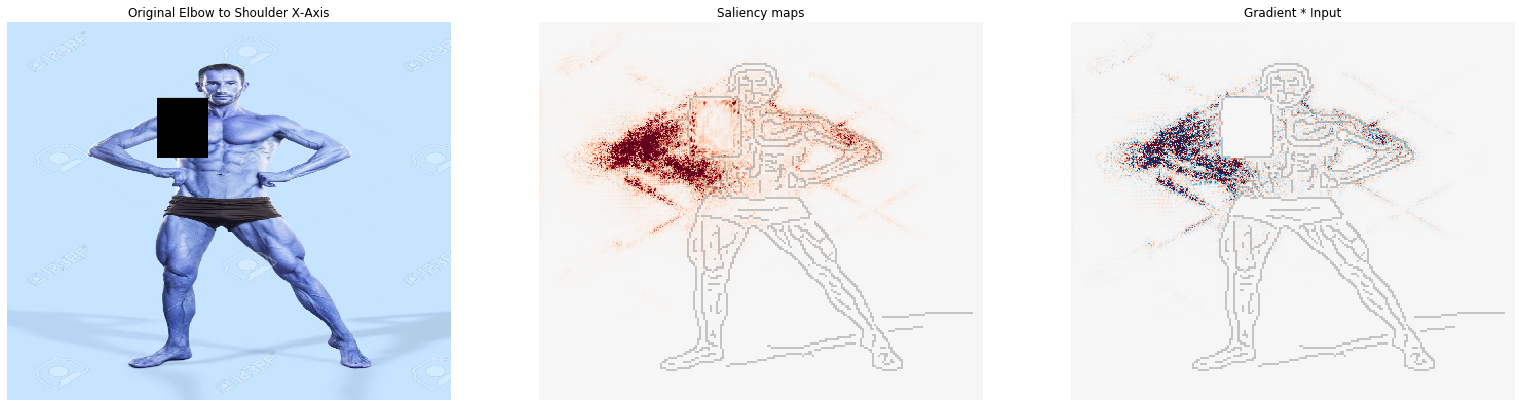

In [8]:
# Plot attributions
%matplotlib inline

n_cols = int(len(attributions)) + 1
n_rows = len(xs)
fig_scale = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(
    3*n_cols*fig_scale, 3*n_rows*fig_scale))

for i, xi in enumerate(xs):
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Original Elbow to Shoulder X-Axis')
    ax.axis('off')
    for j, a in enumerate(attributions):
        axj = axes.flatten()[i*n_cols + j + 1]
        plot(attributions[a][i], xi=xi, axis=axj,
             dilation=.5, percentile=99, alpha=.2).set_title(a)